In [1]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pickle

import cv2

import os
from os import listdir


### File path definition

In [2]:
# Base path to the images folder
# The file structure here is:
#    "Tomato_Leaves" - 
#        - "train"
#           - {Disease Name}
#               - {Disease Name} <- all images for the specific disease
#               - "Tomato_healthy" <- all healthy images copied into folder

# {Disease Folder Name}
# This will also be the name of the saved model
use_path = "Tomato__Tomato_mosaic_virus"

# Path to the dataset folder
# Could change this to a relative path...
root_dir = os.path.abspath("../../Tomato_Leaves")

# All images will be located in sub directories 
# train/Tomato_healthy 
# train/{use_path variable}
train_dir = os.path.join(root_dir, "train/", use_path)

### Image definition

In [3]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 1500

### Numpy array 

In [4]:
# Return image as numpy array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

### Catagories based on folder names
 - use only one catagory at a time

In [5]:
# Load categorical jpg images
# Categories based on containing folder 

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed


### Numpy image list

In [6]:
# Transform the loaded training image data into numpy array
# Note: dtype=np.uint8 is supported for images
np_image_list = np.array(image_list, dtype=np.uint8) / 256
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")


Total number of images: 1873


### Binary pickle for classification names

In [7]:
# Save binary labels to pickle file

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  2


In [8]:
# double check the image shape
np_image_list.shape

(1873, 256, 256, 3)

In [9]:
# Split the data for training
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [10]:
# Verify training split
print("Shape of X_train: ", x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of Y_test: ", y_test.shape)

Shape of X_train:  (1498, 256, 256, 3)
Shape of X_test:  (375, 256, 256, 3)
Shape of Y_train:  (1498, 1)
Shape of Y_test:  (375, 1)


In [11]:
# Prepare the model layers
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\scorp\anaconda3\envs\dev\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
# Train the model
model.fit(x_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7528 - loss: 2.0385
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8063 - loss: 0.4169
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9578 - loss: 0.1282
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9908 - loss: 0.0347
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9976 - loss: 0.0127


In [14]:
model.evaluate(x_test,y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9991 - loss: 0.0110


[0.014312517829239368, 0.9973333477973938]

### Verify model accuracy
- Set healthy image as #1
- Set unhealthy image as #2

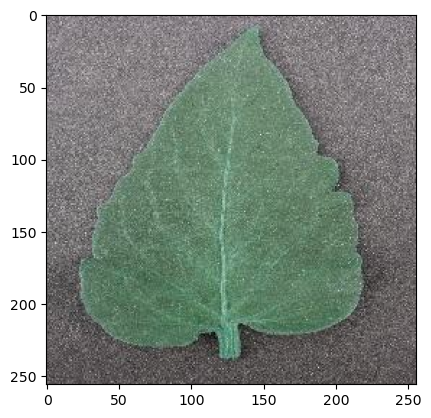

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This leaf is healthy


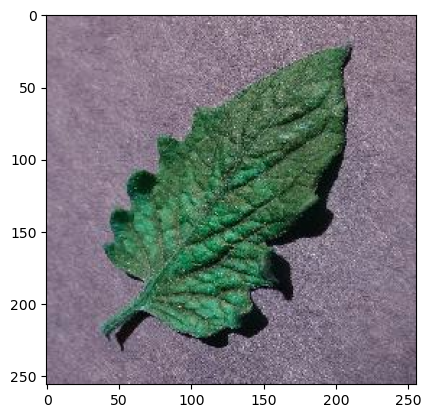

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This leaf is sick


In [17]:
# Load an external image to predict

# Location of your image here
heathy_leaf_dir = "../../Tomato_Leaves/train/" + use_path + "/Tomato_healthy/"
healthy_leaf_files = listdir(heathy_leaf_dir)

# Random healthy leaf image
healthy_leaf = random.randrange(0, len(healthy_leaf_files), 1)
img_test_healthy = (heathy_leaf_dir + healthy_leaf_files[healthy_leaf])

sick_leaf_dir = "../../Tomato_Leaves/train/" + use_path + "/" + use_path + "/"
sick_leaf_files = listdir(sick_leaf_dir)

# Random unhealthy leaf image
unhealthy_leaf = random.randrange(0, len(sick_leaf_files), 1)
img_test_sick = (sick_leaf_dir + sick_leaf_files[unhealthy_leaf])


# Convert loaded image, reshape, and predict
img_convert = convert_image_to_array(img_test_healthy)
np_image = np.array(img_convert, dtype=np.uint8) / 256

plt.imshow(np_image)
plt.show()

y_pred_health = model.predict(np_image.reshape(1,256,256,3))
healthy = y_pred_health > 0.5

if(healthy == 0):
    pred = 'sick'
else:
    pred = 'healthy'

print('This leaf is', pred)

# Convert loaded image, reshape, and predict
img_convert = convert_image_to_array(img_test_sick)
np_image = np.array(img_convert, dtype=np.uint8) / 256

plt.imshow(np_image)
plt.show()

y_pred_sick = model.predict(np_image.reshape(1,256,256,3))
sick = y_pred_sick > 0.5

if(sick == 0):
    pred = 'sick'
else:
    pred = 'healthy'

print('This leaf is', pred)

In [18]:
model.save(use_path + '.h5')

In [19]:
# Show the prediction confidence.
print(y_pred_health[0][0])
print((y_pred_sick[0][0]))

print("The model is {:0.00%}".format(y_pred_health[0][0]) + " sure leaf #1 is healthy")
print("The model is {:0.00%}".format(1-(y_pred_sick[0][0])) + " sure leaf #2 is sick")


0.9999979
0.0003902912
The model is 100% sure leaf #1 is healthy
The model is 100% sure leaf #2 is sick
